# Import Packages

In [29]:
from spectral import *
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,accuracy_score)
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib
import csv
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (8,8)

# Confusion Matrix
Predicton Accuracy

In [30]:
def plot_confusion_matrix(Y_test, Y_pred):
    data = {'y_Actual':    Y_test,
            'y_Predicted': Y_pred
            }
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True)
    plt.show()

# Read Image

In [31]:

def read_poly():
    # open and read image
    print('Reading the image.')
    im_poly = envi.open('C:/Users/stvp2/OneDrive/Documents/UVA PhD/Research/Hyperspectral Imaging/Code/reflectance_image_polymers.hdr')
    im_arr = im_poly.load()
    wl = np.asarray(im_poly.bands.centers)

    # select RGB bands
    if np.mean(wl) < 100:
        # micrometer units
        rgb_bands = [np.argmin(np.abs(wl - 0.450)),
                     np.argmin(np.abs(wl - 0.550)),
                     np.argmin(np.abs(wl - 0.650))]
    else:
        # nanometer units
        rgb_bands = [np.argmin(np.abs(wl - 450)),
                     np.argmin(np.abs(wl - 550)),
                     np.argmin(np.abs(wl - 650))]

    # create the rgb image
    rgb_im = im_arr[:, :, rgb_bands]
    for idx in range(3):
        # determine the upper and lower 2% thresholds
        lower_limit = np.percentile(rgb_im[:, :, idx], 30)
        upper_limit = np.percentile(rgb_im[:, :, idx], 90)
        # truncate by the upper and lower limits
        rgb_im[:, :, idx][rgb_im[:, :, idx] < lower_limit] = lower_limit
        rgb_im[:, :, idx][rgb_im[:, :, idx] >= upper_limit] = upper_limit
        # stretch to a 0-255 scale
        rgb_im[:, :, idx] = rgb_im[:, :, idx] - lower_limit
        rgb_im[:, :, idx] = 255 * rgb_im[:, :, idx] / (upper_limit - lower_limit)
    rgb_img_show = Image.fromarray(rgb_im.astype(np.uint8), 'RGB')

    # locations of boxes for materials [[ULr,ULc],[BRr,BRc]]
    print('Extracting class spectra.')
    loc = {
        'red_bubble_wrap': [[415,125],[466,197]],
        'clear_bubble_wrap': [[366,265],[457,298]],
        'glove_loc': [[528,262],[548,322]],
        'medicine_bottle': [[261,193],[329,213]],
        'red_lid': [[284,108],[335,166]],
        'ping_pong_ball': [[350,90],[365,105]],
        'pvc_pipe': [[249,340],[610,355]],
        'pvc_extension_plug': [[458,8],[559,26]],
        'inflatable_football': [[609,82],[656,150]],
        'foam_packaging': [[720,220],[809,320]]
        }

    # read the spectra for the classes into a dictionary
    data = {}
    for key in loc.keys():
        # need to get this working:
        [[RowStart, ColStart], [RowEnd, ColEnd]] = loc[key]
        class_arr = im_arr[RowStart:RowEnd, ColStart:ColEnd, :]
        shp = class_arr.shape
        data[key] = np.reshape(class_arr, [shp[0]*shp[1],shp[2]])

    # get the names of the classes
    material_names = data.keys()
    nClasses = len(material_names)
    nBands = len(wl)
    print('Number of classes: '+str(nClasses))
    for name in material_names:
        print('Number of spectra in class '+name+': '+str(data[name].shape[0]))
    print('Number of bands (features): '+str(nBands))

    # create standard X,Y data
    print('Formatting data.')
    index = 0
    for name in material_names:
        if index == 0:
            X = data[name]
            Y = np.zeros(data[name].shape[0])
            index = index + 1
        else:
            X = np.concatenate((X, data[name]))
            Y = np.concatenate((Y, index*np.ones(data[name].shape[0]) ))
            index = index + 1

    return X, Y, im_poly, im_arr, wl, rgb_img_show, rgb_bands, material_names, data

# READ DATA:

In [32]:
X, Y, im_poly, im_arr, wl, rgb_img_show, rgb_bands, material_names, data = read_poly()

Reading the image.
Extracting class spectra.
Number of classes: 10
Number of spectra in class red_bubble_wrap: 3672
Number of spectra in class clear_bubble_wrap: 3003
Number of spectra in class glove_loc: 1200
Number of spectra in class medicine_bottle: 1360
Number of spectra in class red_lid: 2958
Number of spectra in class ping_pong_ball: 225
Number of spectra in class pvc_pipe: 5415
Number of spectra in class pvc_extension_plug: 1818
Number of spectra in class inflatable_football: 3196
Number of spectra in class foam_packaging: 8900
Number of bands (features): 452
Formatting data.


In [33]:
# to show the image:
rgb_img_show.show()

# 1. Linear Discriminant Analysis (LDA)

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=42, stratify=Y)
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, Y_train)
# predict on train data
Y_pred_train = LDA.predict(X_train)
accuracy_train = np.sum(Y_pred_train == Y_train)/len(Y_train)
# predict on test data
Y_pred = LDA.predict(X_test)
accuracy = np.sum(Y_pred == Y_test)/len(Y_test)
print('Train set size: '+str(len(Y_train))+'| LDA train accuracy: '+str(accuracy_train)+'| LDA test accuracy: '+str(accuracy))

Train set size: 22222| LDA train accuracy: 0.9996849968499685| LDA test accuracy: 0.9991601049868767


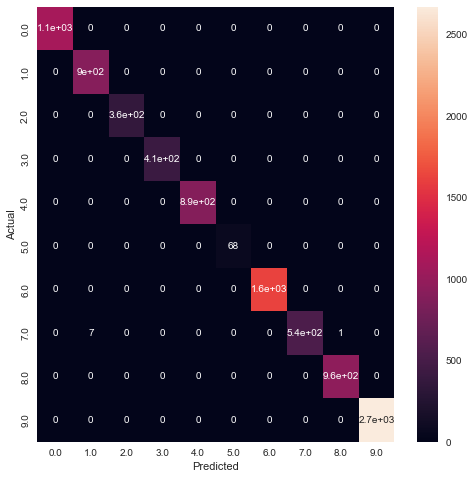

In [35]:
plot_confusion_matrix(Y_test, Y_pred)

# 2. Quadratic Discriminant Analyis (QDA) 

In [36]:
QDA_model = QuadraticDiscriminantAnalysis()
QDA_model.fit(X_train, Y_train)
y_pred_QDA_train = QDA_model.predict(X_train)
accuracy_train = np.sum(y_pred_QDA_train == Y_train)/len(Y_train)
Y_pred_QDA_test = QDA_model.predict(X_test)
accuracy = np.sum(Y_pred_QDA_test == Y_test)/len(Y_test)
print('Train set size: '+str(len(Y_train))+'| LDA train accuracy: '+str(accuracy_train)+'| LDA test accuracy: '+str(accuracy))

c:\Users\stvp2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Train set size: 22222| LDA train accuracy: 1.0| LDA test accuracy: 0.9932808398950131


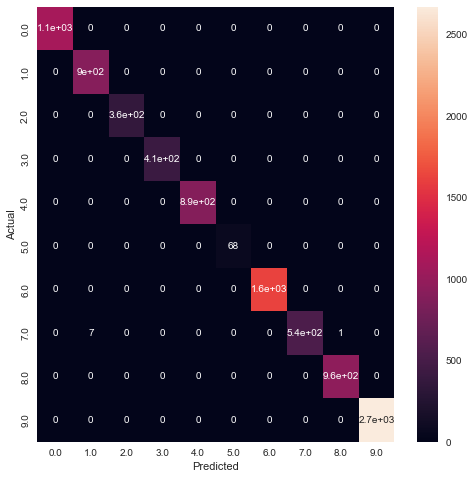

In [37]:
plot_confusion_matrix(Y_test, Y_pred)

# 3. Logistic Regression

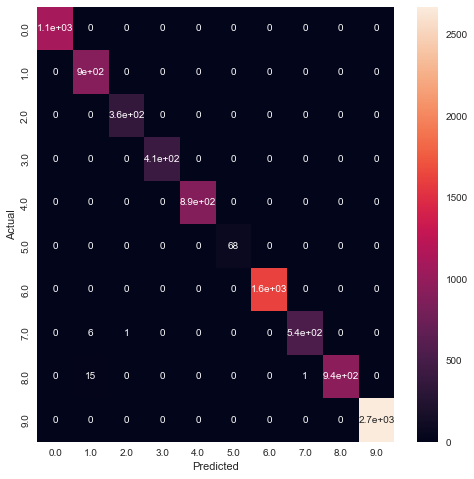

In [50]:
logistic_model = LogisticRegression(solver='liblinear', random_state=0)
logistic_model.fit(X_train, Y_train)
lr_prob = logistic_model.predict_proba(X_test)
Y_pred = logistic_model.predict(X_test)
logistic_model.score(X_test, Y_test)
plot_confusion_matrix(Y_test, Y_pred)
# how do we do the logistic regression with more than two classifications 

In [49]:
print("Prbobality", lr_prob[-1,:])
print("Class", Y_pred)
print(np.shape(lr_prob))
print(np.shape(Y_pred))

Prbobality [6.53184431e-16 2.05718449e-12 9.56196739e-08 9.32973615e-01
 2.21169218e-08 2.44354098e-03 1.52394367e-02 8.46274633e-03
 9.15077201e-09 4.08805336e-02]
Class [6. 9. 4. ... 1. 1. 3.]
(9525, 10)
(9525,)


# 4. K-Nearest Neighbors (KNN) 
(parameter = k)

In [39]:
#Useful Links:
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    # https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
    # https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761
old_accuracy = float(0.0)
graph_dict = {}
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=42, stratify=Y)
for i in np.arange(1, 20):
    #print("Test is on k = %d:"%i)
    knn1 = KNeighborsClassifier(n_neighbors=i)
    knn1.fit(X_train, Y_train)
    Y_pred = knn1.predict(X_test)
    new_accuracy = metrics.accuracy_score(Y_test, Y_pred)
    #print("  Accuracy:",new_accuracy)
    graph_dict [i] = new_accuracy
    if new_accuracy > old_accuracy:
        chosen_k = i
        old_accuracy = new_accuracy
        Best_Y_test = Y_test
        Best_Y_Pred = Y_pred 
print("The best k = %d accuracy is"%chosen_k, old_accuracy)

The best k = 1 accuracy is 0.9997900262467192


Prediction Accuracy Plot as K Increases

Text(0, 0.5, 'Accuracy')

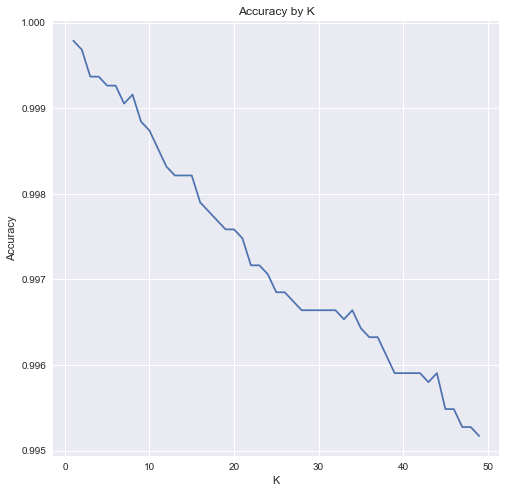

In [40]:
x_values = graph_dict.keys() 
y_values = graph_dict.values()
plt.plot(x_values,y_values)
plt.title("Accuracy by K")
plt.xlabel("K")
plt.ylabel("Accuracy")

Scatter Plot of Subset (1000 pts) of Data

C:\Users\stvp2\AppData\Local\Temp\ipykernel_57808\931928957.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_index = np.random.randint(0, len(Y), size=1000, dtype=np.int)


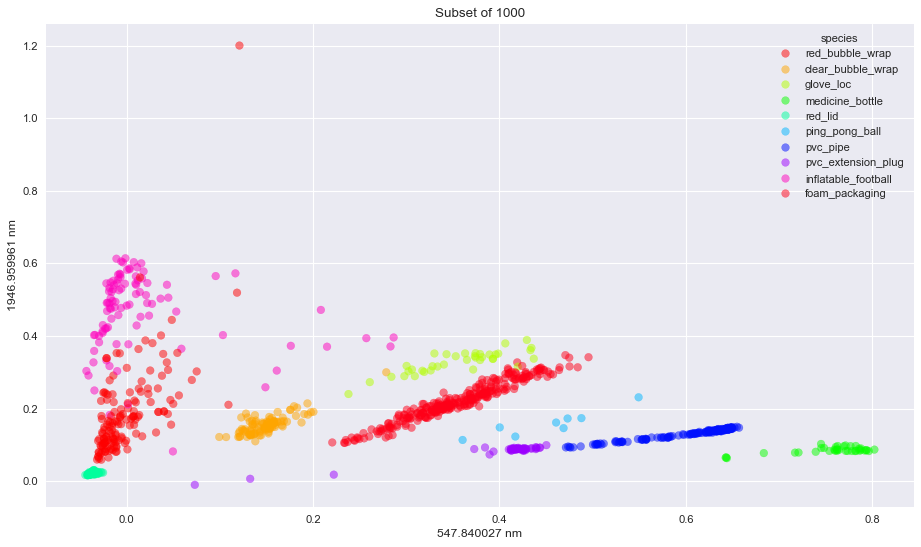

In [41]:
sample_index = np.random.randint(0, len(Y), size=1000, dtype=np.int)
x_band = 50
y_band = 350
graph_x = X[sample_index,x_band]
graph_y = X[sample_index,y_band]
graph_labels = Y[sample_index]
plt.figure(figsize=(14, 8), dpi=80)
scatter = plt.scatter(graph_x, graph_y, c = graph_labels, cmap='hsv', alpha=.5)
plt.title("Subset of 1000")
plt.xlabel(str(wl[x_band])+" nm")
plt.ylabel(str(wl[y_band])+" nm")
plt.legend(handles=scatter.legend_elements()[0],
           labels=list(material_names),
           title="species")


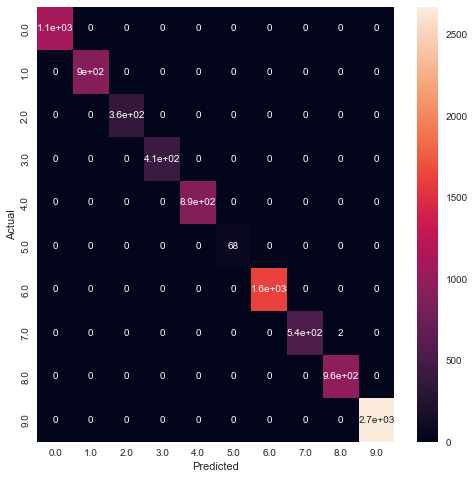

In [42]:
plot_confusion_matrix(Best_Y_test, Best_Y_Pred)